In [1]:
%matplotlib inline
# imports required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pynetlogo
import numpy as np
import sys
sys.path.append('../')

from LandLab_experiments.ecohydr_mod import EcoHyd

In [2]:
def get_yearly_temp(csv_path, num_years):
    df = pd.read_csv(csv_path)
    df.dt = pd.to_datetime(df.dt)
    avg_temp_per_year = []
    max_temp_per_year = []
    min_temp_per_year = []
    for year in range(0, num_years):
        earliest_yr = df.iloc[0, 0].year
        year = year + earliest_yr
        if len(df.loc[(df.dt.dt.year == year), :]) > 365:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].iloc[:-1].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].iloc[:-1].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].iloc[:-1].tolist())
        else:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].tolist())
    
    return avg_temp_per_year, max_temp_per_year, min_temp_per_year

yearData = get_yearly_temp("/Users/mabelwylie/Documents/NetLogo-MOSS-Python/CouplingRepo/TreesAndThat/LandLab_experiments/new_temp_data.csv", 10)

In [3]:
def setUpNetLogoModel(leadFarmers, desperation, jealousy, grace):
    # think this is for the GUI idk?
    sns.set_style("white")
    sns.set_context("talk")

    # starts a NetLogo link, point the netlogo home path to where you have it installed on your machine
    netlogo = pynetlogo.NetLogoLink(
        gui=False,
        netlogo_home="/Volumes/NetLogo 6.3.0/NetLogo 6.3.0"
    )

    # loads a .nlogo model from provided path
    netlogo.load_model("/Users/mabelwylie/Documents/NetLogo-MOSS-Python/CouplingRepo/TreesAndThat/Coupling/modelv2.nlogo")

     # sets globals
    globals = "update-globals " + str(leadFarmers) + " " + str(desperation) + " " + str(jealousy) + " " + str(grace)
    #netlogo.command(globals)
    
    # runs the model setup command
    netlogo.command("setup")

    return netlogo

In [4]:
def reportsToDataFrame(netlogo):
    # gets field attributes and puts it in a data frame
    fieldAttributes = netlogo.report("get-info")
    sorted_list = sorted(fieldAttributes, key=lambda x: (-x[1],x[0]))
    fieldData = pd.DataFrame(columns=["who", "xcor","ycor","owner-id","implements-WSA", "yield"], data=sorted_list)
    return fieldData

In [5]:
def convertWSAToNPArray(data):
    # sets bool into correct format to pass to hydrology model
    emptynp = np.empty((51,51))
    for i in range(0,51):
        for j in range(0,51):
            ycorFromIndex = i * -1 + 25
            xcorFromIndex = j - 25
            emptynp[i][j]= data.loc[(data['ycor'] == ycorFromIndex) & (data['xcor'] == xcorFromIndex)]["implements-WSA"].iloc[0]
    return emptynp

In [6]:
def convertHydrologyToDF(hydrologyArray, data):
    # method converts the hydrology model output into a pandas dataframer
    hydrologyDataTemp = np.reshape(hydrologyArray, (51,51))
    flattenedArray = hydrologyDataTemp.flatten()
    # 2 is the placeholder to multiply the biomass to get yield
    hydrologyData = data.copy()
    hydrologyData["yield"] = flattenedArray
    return hydrologyData

year: 0
converted to NP array
0
0
soil moisture sat.: [ 0.60745363  0.60743388  0.60741494 ...,  0.62157797  0.62159237
  0.62160734]
live biomass:  [ 0.  0.  0. ...,  0.  0.  0.]
ET:  [ 4.94228682  4.9441125   4.94586239 ...,  3.61038351  3.60899683
  3.60755525]
ET30:  [ 4.94228682  4.9441125   4.94586239 ...,  3.61038351  3.60899683
  3.60755525]
PFT:  [3 3 3 ..., 3 3 3]
0
0
soil moisture sat.: [ 0.53066848  0.53062479  0.53058291 ...,  0.56063701  0.56066585
  0.56069584]
live biomass:  [ 0.  0.  0. ...,  0.  0.  0.]
ET:  [ 5.04819152  5.05005632  5.05184371 ...,  3.68774781  3.68633142
  3.68485895]
ET30:  [ 5.04819152  5.05005632  5.05184371 ...,  3.68774781  3.68633142
  3.68485895]
PFT:  [3 3 3 ..., 3 3 3]
1
0.0027397260273972603
soil moisture sat.: [ 0.46662289  0.4665507   0.46648149 ...,  0.5173319   0.51738231
  0.51743471]
live biomass:  [ 0.  0.  0. ...,  0.  0.  0.]
ET:  [ 4.97682978  4.97866822  4.98043034 ...,  3.63899675  3.63759908
  3.63614607]
ET30:  [ 4.97682978  

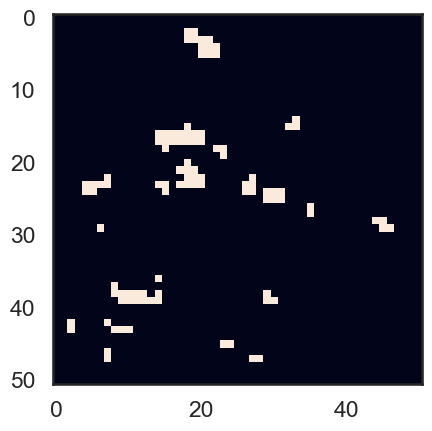

In [13]:
def fullModelRun(leadFarmers, desperation, jealousy, grace, fileSuffix, input_csv_path, no_of_years):
    # sets up model
    netlogo = setUpNetLogoModel(leadFarmers, desperation, jealousy, grace)

    # this will record all field attributes throughout the simulation - need to add year index to differentiate
    baseFieldData = reportsToDataFrame(netlogo)

    returnedData = baseFieldData.copy()
    
    baseFieldData["Year"] = 0

    WSA_records = []


    #get input temperature data
    avg, maxi, mini = get_yearly_temp(input_csv_path, no_of_years)

    Ecohyd_model = EcoHyd(20, 26, 23)

    for year in range(0, no_of_years):
        print("year:", year)
        # gets 3 lists of length 365 for the year of the simulation
        avg_yr, maxi_yr, mini_yr = avg[year], maxi[year], mini[year]

        # converts the usingWSA bool for each field into an NP array
        WSA_array = convertWSAToNPArray(returnedData)
        WSA_records.append([WSA_array])
        plt.imshow(WSA_array)
        print("converted to NP array")

        biomass_harvest, SM_canic_end = Ecohyd_model.stepper(WSA_array, avg[year], maxi[year], mini[year])
        #hydrologyOutput = hydrologyModelYear(WSA_array)
        

        # converts the updated yields to the dataframe
        hydrologyData = convertHydrologyToDF(biomass_harvest,returnedData)
        print("Converted output to df")

        # writes this new yield information to the netlogo implementation
        netlogo.write_NetLogo_attriblist(hydrologyData, "field")
        print("wrote to netlogo")

        # runs one step of social model
        netlogo.command("farming-year")
        print("farming command")

        # converts field data to a df
        returnedData = reportsToDataFrame(netlogo)
        print("convertedtoDF")

        dataToRecord = returnedData.copy()
        
        dataToRecord["Year"] = year + 1

        # adds this years results to the dataframe
        baseFieldData = pd.concat([baseFieldData, dataToRecord], ignore_index=True)

    return baseFieldData, WSA_records
    

        

## dummy hydrology model to test running
def hydrologyModelYear(input):
    print("One year yield")
    return 100 * np.ones((51,51))

# haven't got setup with globals actually working yet, manually change in the NetLogo Code
baseFieldData, WSA_records = fullModelRun(20, 50, 50, 3, 2, "new_temp_data.csv", 4)

In [8]:
print(baseFieldData.loc[baseFieldData["implements-WSA"] == 1].groupby(["Year"]).sum())

Empty DataFrame
Columns: [who, xcor, ycor, owner-id, implements-WSA, yield]
Index: []


In [35]:
print(baseFieldData.groupby(["Year", "implements-WSA"]).mean())

                             who      xcor      ycor    owner-id       yield
Year implements-WSA                                                         
0    0.0             2102.842002  0.059496 -0.005910  401.057920  100.000000
     1.0             1985.507937 -2.396825  0.238095  404.809524  100.000000
1    0.0             2102.842002  0.059496 -0.005910  401.057920   75.921742
     1.0             1985.507937 -2.396825  0.238095  404.809524   79.986998
2    0.0             2102.995244  0.144669  0.000396  400.011098   66.068068
     1.0             2003.115385 -4.679487 -0.012821  437.948718   65.091627
3    0.0             2102.474590  0.248499 -0.011204  401.397359   62.694645
     1.0             2039.372549 -6.088235  0.274510  395.058824   59.524678
4    0.0             2102.482982  0.445300  0.040924  401.442869   71.625933
     1.0             2053.924812 -8.263158 -0.759398  395.691729   62.703776


Text(0.5, 0.98, 'WSA field spread')

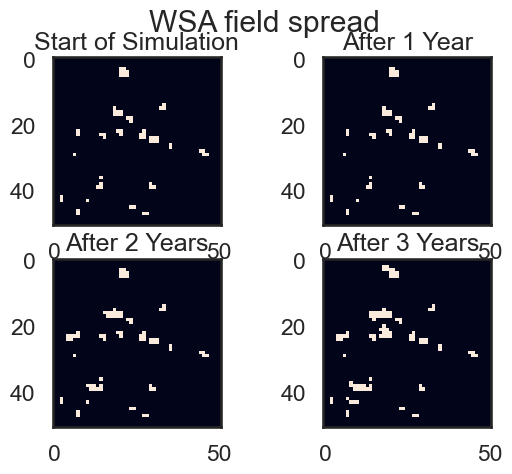

In [50]:
fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(WSA_records[0][0])
ax[0][0].set_title("Start of Simulation")
ax[0][1].imshow(WSA_records[1][0])
ax[0][1].set_title("After 1 Year")
ax[1][0].imshow(WSA_records[2][0])
ax[1][0].set_title("After 2 Years")
ax[1][1].imshow(WSA_records[3][0])
ax[1][1].set_title("After 3 Years")
plt.suptitle("WSA field spread")

Text(0.5, 1.0, 'Average yield of fields by WSA type')

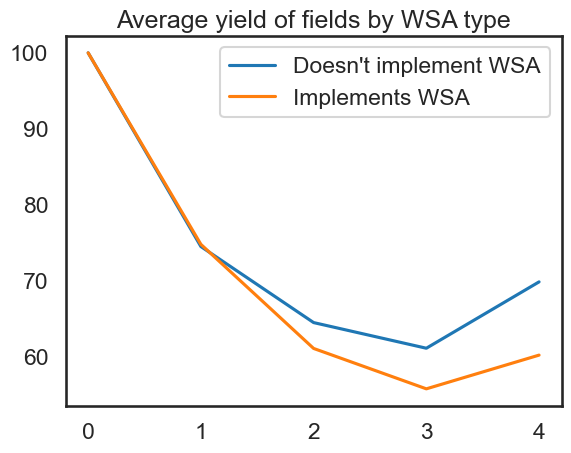

In [53]:
avgyielddata = baseFieldData.groupby(["Year", "owner-id"]).mean().reset_index().groupby(["Year","implements-WSA"]).mean().reset_index()

nonImp = avgyielddata.loc[avgyielddata["implements-WSA"] == 0]
imp = avgyielddata.loc[avgyielddata["implements-WSA"] == 1]

plt.plot(nonImp["Year"], nonImp["yield"], label = "Doesn't implement WSA")
plt.plot(imp["Year"], imp["yield"], label = "Implements WSA")
plt.legend()
plt.title("Average farmer yield by WSA type")

Text(0.5, 1.0, 'Number of farmers using each technique')

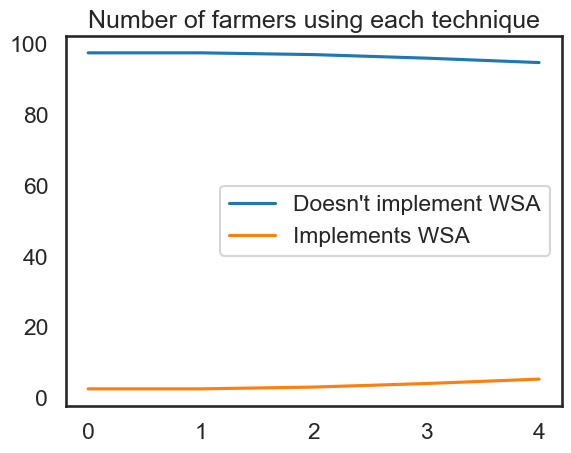

In [70]:
proportionData = baseFieldData.groupby(["Year","implements-WSA","owner-id"]).mean().reset_index().groupby(["Year","implements-WSA"])["yield"].count().reset_index()

proportionData["percentage"] = proportionData["yield"] / 800 * 100

nonImp = proportionData.loc[proportionData["implements-WSA"] == 0]
imp = proportionData.loc[proportionData["implements-WSA"] == 1]

plt.plot(nonImp["Year"], nonImp["percentage"], label = "Doesn't implement WSA")
plt.plot(imp["Year"], imp["percentage"], label = "Implements WSA")
plt.legend()
plt.title("Number of farmers using each technique")